In [35]:
#This notebook was originally copied from https://www.kaggle.com/samiaimad/ai-uni-project. 
#This copy is to make changes of my own 
#using virtual environment VoiceRec1
#Rogier Landman 2022

import pandas as pd
import numpy as np
import os
import sys
import glob
import re
import splitfolders
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import soundfile as sf

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import pylab

import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Assigning Data Paths to Variables**

In [4]:
Ravdess = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24"
CremaD = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Crema-D_dataset/AudioWAV"
Tess = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data"
Savee = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData"


# **Audio Classification from the ravdess-emotional-speech-audio data set**

In [9]:
ravdess=glob.glob(Ravdess + "/*/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]
for i in ravdess:
    #print(i)
    isplit= i.split('.')[0]
    isplit=isplit.split('-')
    emotion.append(int(isplit[2]))
    gend=int(isplit[6])
    if gend%2==0:
        gender.append('Female')
    else:
        gender.append('Male')
    intensity.append(int(isplit[3]))
    for sp in emotion:
        if sp=="1":
            intensity.append('Normal')
    path.append(i)
edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

ravdess_df=pd.concat([edf, pdf, gdf, idf], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.Intensity.replace({1:'Normal', 2:'Strong'}, inplace=True)
ravdess_df.head()
ravdess_df.isnull()
ravdess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   1440 non-null   object
 1   Path       1440 non-null   object
 2   Gender     1440 non-null   object
 3   Intensity  1440 non-null   object
dtypes: object(4)
memory usage: 45.1+ KB


# **Audio Classification from the cremad data set**

In [10]:
crema=glob.glob(CremaD + "/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]
for f in crema:
    part2= Path(f).stem
    part2=part2.split('_')
    #print(part2)
    if int(part2[0])%2==0:
        gender.append('Female')
    else:
        gender.append('Male')
        
    if part2[2] == 'SAD':
        emotion.append('sad')
    elif part2[2] == 'ANG':
        emotion.append('angry')
    elif part2[2] == 'DIS':
        emotion.append('disgust')
    elif part2[2] == 'FEA':
        emotion.append('fear')
    elif part2[2] == 'HAP':
        emotion.append('happy')
    elif part2[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('Unknown')
        
    if part2[3]=='HI':
        intensity.append('High')
    elif part2[3]=='LO':
        intensity.append('Low')
    elif part2[3]=='MD':
        intensity.append('Medium')
    elif part2[3]=='XX':
        intensity.append('Unspecified')
        
    path.append(f)
    
edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

crema_df=pd.concat([edf, pdf, gdf, idf], axis=1)
crema_df.head()
crema_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   7442 non-null   object
 1   Path       7442 non-null   object
 2   Gender     7442 non-null   object
 3   Intensity  7441 non-null   object
dtypes: object(4)
memory usage: 232.7+ KB


# **Audio Classification from the toronto-emotional-speech-set-tess data set**

In [11]:
tess=glob.glob(Tess + "/*/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]

for i in tess:
    part2= Path(i).stem
    fsplit=part2.split('_')[2]
    if fsplit=='ps':
        emotion.append('surprise')
    else:
        emotion.append(fsplit)
    gender.append('Female')
    path.append(i)
    intensity.append('Unspecified')
        
edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

tess_df=pd.concat([edf, pdf, gdf, idf], axis=1)
tess_df.head()
tess_df.isnull()
tess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   2800 non-null   object
 1   Path       2800 non-null   object
 2   Gender     2800 non-null   object
 3   Intensity  2800 non-null   object
dtypes: object(4)
memory usage: 87.6+ KB


# **Audio Classification from Savee Dataset**

In [12]:
savee=glob.glob(Savee + "/*/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]

for f in savee:
    #dsplit = d.split(".")[0]
    #llsplit=re.split('\d+',dsplit[0])
    #print(llsplit)
    part2= Path(f).stem
    elist=part2[0]
    if elist=='a':
        emotion.append('angry')
    elif elist=='d':
        emotion.append('disgust')
    elif elist=='f':
        emotion.append('fear')
    elif elist=='h':
        emotion.append('happy')
    elif elist=='n':
        emotion.append('neutral')
    elif elist=='sa':
        emotion.append('sad')
    else:
        emotion.append('surprise')
    gender.append('Male')
    path.append(f)
    intensity.append('Unspecified')

edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

savee_df=pd.concat([edf, pdf, gdf, idf], axis=1)
#savee_df.head()
savee_df.isnull()
savee_df.info()
savee_df.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   480 non-null    object
 1   Path       480 non-null    object
 2   Gender     480 non-null    object
 3   Intensity  480 non-null    object
dtypes: object(4)
memory usage: 15.1+ KB


,Emotions,Path,Gender,Intensity
475,surprise,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
476,happy,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
477,fear,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
478,fear,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
479,neutral,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified


# **Combining DataFrames (ravdess_df, crema_df,tess_df, savee_df)**

In [13]:
Data_Combined = pd.concat([ravdess_df, crema_df,tess_df, savee_df], axis = 0, ignore_index = True)
Data_Combined.isnull()
Data_Combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12162 entries, 0 to 12161
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   12162 non-null  object
 1   Path       12162 non-null  object
 2   Gender     12162 non-null  object
 3   Intensity  12161 non-null  object
dtypes: object(4)
memory usage: 380.2+ KB


In [8]:
Data_Combined.tail()

,Emotions,Path,Gender,Intensity
12157,surprise,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
12158,happy,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
12159,fear,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
12160,fear,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
12161,neutral,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified


# **Data Visualization**

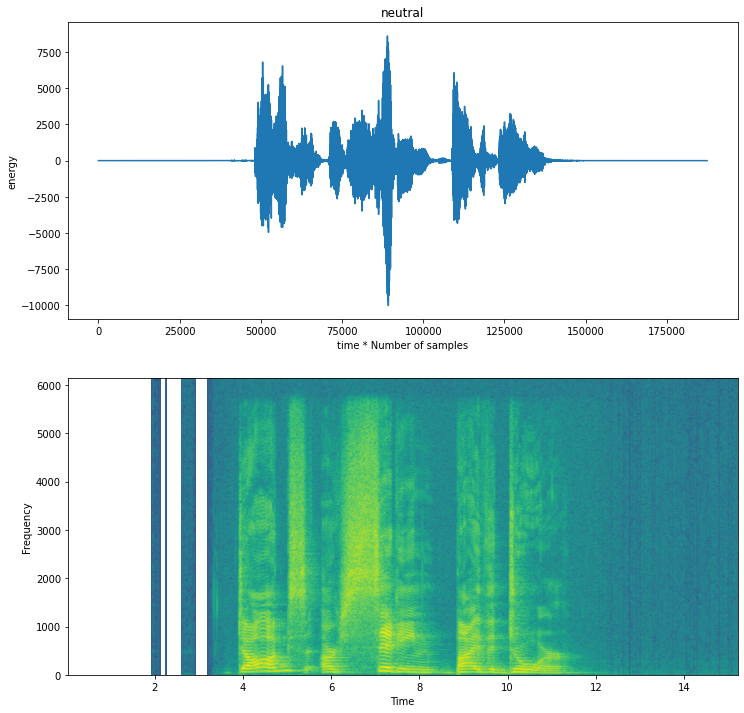

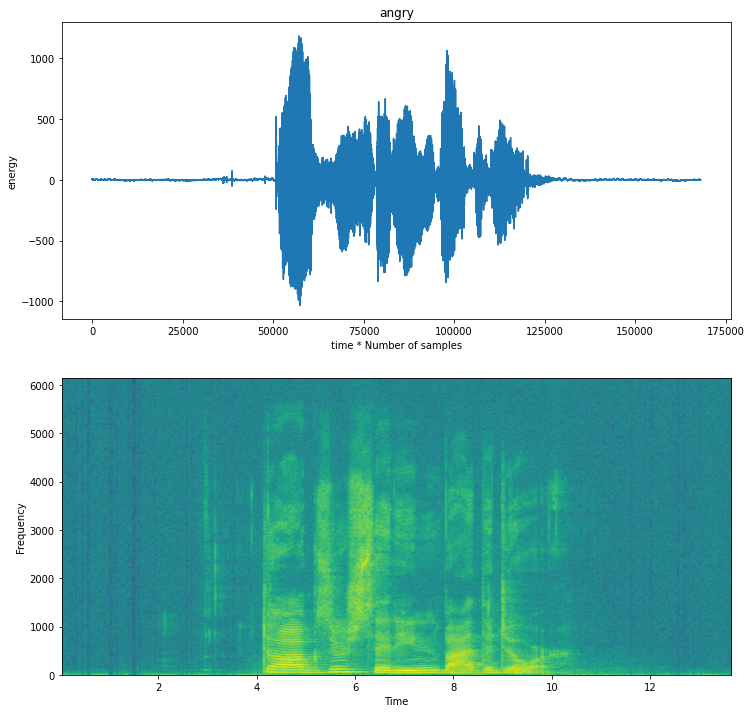

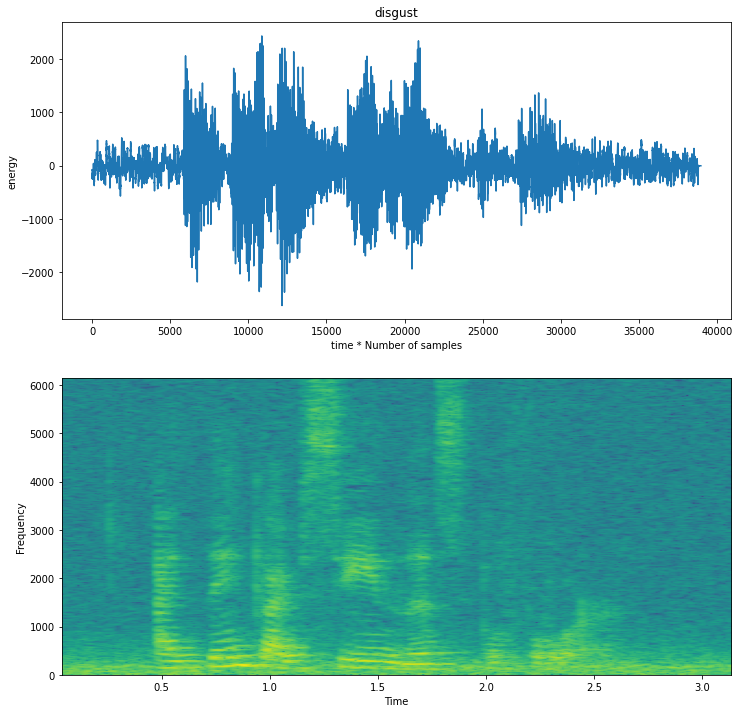

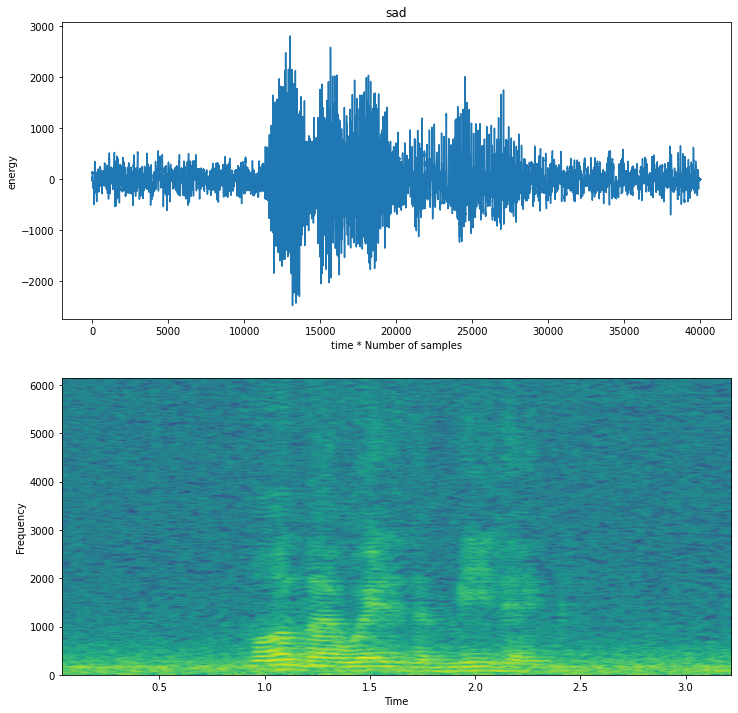

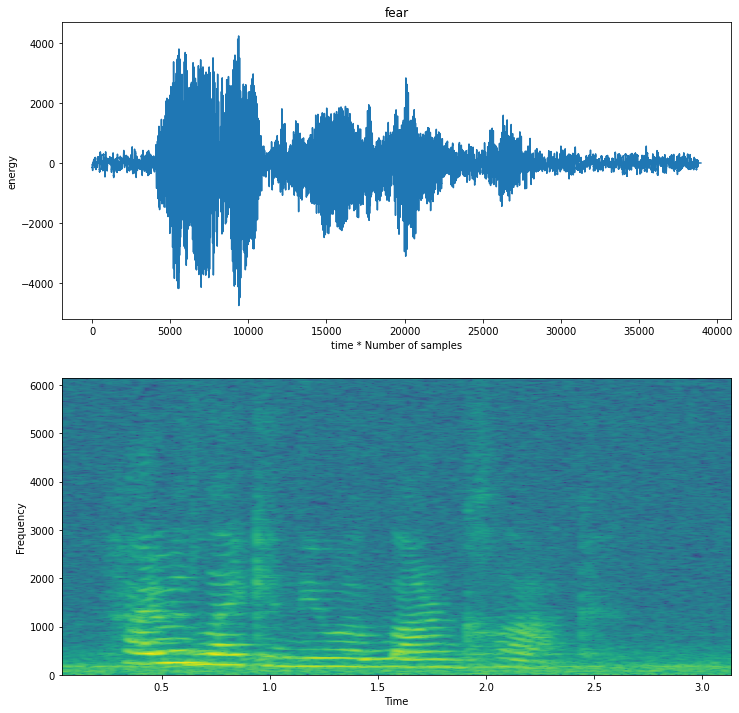

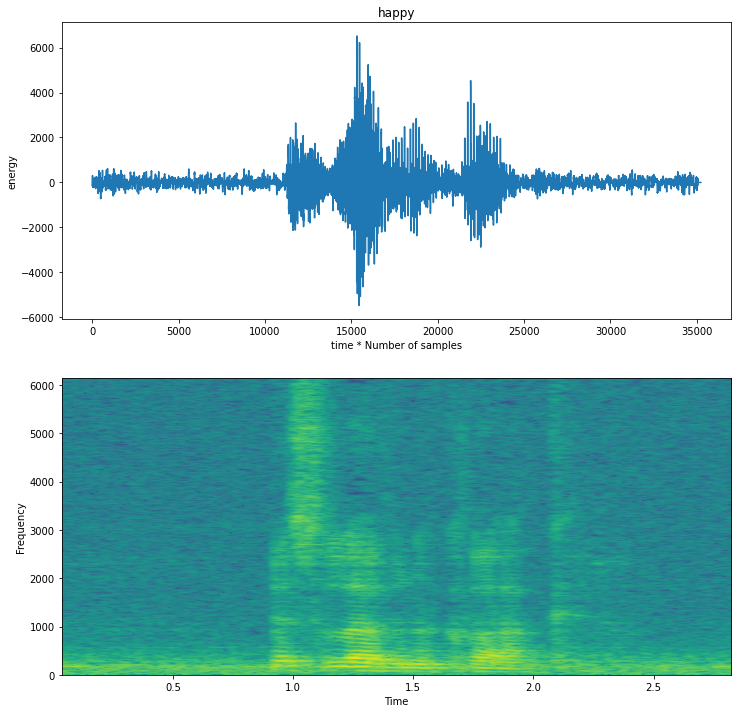

In [9]:
x = []
flag = 0

while (flag != 2000): 
   
    audio = wave.open(Data_Combined.iloc[flag, 1], 'r')
    flag = flag + 1 
    y= Data_Combined.iloc[flag, 0]
    if (len(x)>10):
        flag=2000    

    if (y not in x):
        signal = np.frombuffer(audio.readframes(-1), dtype=np.int16)
        plt.figure(figsize=(12,12))
        plot1 = plt.subplot(211)
        plot1.set_title(Data_Combined.iloc[flag, 0])
        plot1.plot(signal)
        plot1.set_xlabel('time * Number of samples')
        plot1.set_ylabel('energy')

        plot2 = plt.subplot(212)
        plot2.specgram(signal, NFFT=1024, Fs=12281, noverlap=900)
        plot2.set_xlabel('Time')
        plot2.set_ylabel('Frequency')
        
        x.append(y)

plt.show()

# **Data Augmentation**

In [42]:
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate)
#x , sr = librosa.load(stretch(audio_data))
#ya = stretch(x)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

#SNR = 20*log(RMS_s/RMS_n)


In [39]:
def white_noise(data,SNR):
    RMS_s=math.sqrt(np.mean(data**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, data.shape[0])
    data_noise=noise+data
    return data_noise 
    
#x , sr = librosa.load(audio_data)
#ya = white_noise(x,SNR=10)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

In [37]:
def shifting_time(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

#x , sr = librosa.load(audio_data)
#ya = shifting_time(x,sr,shift_max=1.5,shift_direction='right')
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

In [43]:
def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
#x , sr = librosa.load(audio_data)
#ya = pitch(x,sr,pitch_factor=0.5)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

# **Creating Spectograms images from Audio files**

In [29]:
from pathlib import Path
import pylab

bad_ones = []

output_path="/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/"
if  not os.path.exists(os.path.join(output_path, 'audio-spectrograms')):
    os.mkdir(os.path.join(output_path, 'audio-spectrograms'))
    
#function to get sound and frame rate info
def get_audio_info(audio_path):
    wav = wave.open(audio_path, 'r')
    frames = wav.readframes(-1)
    audio_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return audio_info, frame_rate

for f in range (len(Data_Combined)):
        file_Path = f'{Data_Combined.iloc[f, 1]}'
        #print (file_path)
        file_stem = Path(file_Path).stem
        #print (file_stem)
        target_dir = f'class_{Data_Combined.iloc[f, 0]}'
        #print (target_dir)
        dist_dir = os.path.join(os.path.join(output_path, 'audio-spectrograms'), target_dir)
        #print (dist_dir)
        # ex: ./audio-spectrograms/class_fear
        file_dist_path = os.path.join(dist_dir, file_stem)
        #ex: ./audio-spectrograms/class_fear/03-01-06-02-02-01-10
        
    
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_Path).stem
            try:
                audio_info, frame_rate = get_audio_info(file_Path)
                pylab.specgram(audio_info, Fs=frame_rate)
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
                print(file_Path)
            except:
                bad_ones.append(file_Path)
                print('BAD: ' + file_Path)

BAD: /Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_neat_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_ditch_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_back_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_live_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_third_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_gap_fear.wav
/Use

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_keep_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_red_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_shack_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_calm_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_doll_fear.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_boat_fear.wav
/Users/rog

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_book_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_search_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_keen_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_team_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_tape_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_n

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_hole_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_wheat_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_hush_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_half_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_perch_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_n

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_late_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_gas_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_said_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_neat_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_rose_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neut

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_met_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_kite_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_take_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_near_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_check_neutral.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neu

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_voice_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_rush_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_sheep_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_pass_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_haze_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_d

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_cool_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_week_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_turn_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_far_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_chief_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_dis

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_sure_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_search_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_book_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_keen_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_tape_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_d

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_learn_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_third_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_goose_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_came_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_wife_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_tool_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_should_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_puff_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_walk_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_white_disgust.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_doll_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_judge_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_sub_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_tire_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_goose_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_hit_angry.wa

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_kite_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_gin_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_hall_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_wire_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_limb_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_wash_angry.wav

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_back_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_wheat_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_tough_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_shout_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_laud_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_live_angry

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_witch_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_sour_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_walk_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_thin_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_week_angry.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_pike_angry.w

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_merge_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_nice_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_keep_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_pad_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_wheat_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_yes_sad.wav
/Users/rogierlandman/f

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_door_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_witch_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_get_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_pike_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_kite_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_turn_sad.wav
/Users/rogierlandman/f

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_rose_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_shirt_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_read_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_sheep_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_far_sad.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_mob_sad.wav
/Users/rogierlandman/f

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/n03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/h05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/sa04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/h11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/sa10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/d08.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/d09.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/sa11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/h10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/sa05.wav
/Users/rogierlandman/from_Samsung/Machine_lear

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/d02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/d03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/f01.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/f15.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/n20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/n08.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/n24.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/n30.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/n18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData/KL/f11.wav
/Users/rogierlandman/from_Samsung/Machine_learning

In [ ]:
#this would be done if you augment audio but then you need time to calculate spectrograms as well

#loop through wav files and augment .. 
dest_dir = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/augment/audio/'

for f in range (len(Data_Combined)):
 
    file_Path = f'{Data_Combined.iloc[f, 1]}'
    print(file_Path)
    x, sr = librosa.load(file_Path)
    file_stem = Path(file_Path).stem

    #pick value for pitch shift
    pick = random.uniform(-1,1)
    x = pitch(x,sr, pitch_factor = pick)

    #pick value for time shift
    pick = random.uniform(0,0.5)
    x = shifting_time(x,sr,shift_max=pick,shift_direction='both')

    #pick value for time shift
    pick = random.uniform(0,5)
    x = white_noise(x,SNR=pick)

    #pick value for time stretch
    pick = random.uniform(0,0.8)
    x = stretch(x, pick)

    target_dir = f'class_{Data_Combined.iloc[f, 0]}'
    dest_dir1 = os.path.join(dest_dir, target_dir)
    dest_path = os.path.join(dest_dir1, file_stem + '_aug1.wav')

    if not os.path.exists(dest_dir1):
        os.mkdir(dest_dir1)


    sf.write(dest_path, ya, sr, 'PCM_16')
   

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_16/03-01-06-01-02-02-16.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_16/03-01-06-02-01-02-16.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_16/03-01-05-02-01-01-16.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_16/03-01-07-01-01-01-16.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_16/03-01-04-01-01-02-16.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_16/03-01-04-02-02-02-16.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_11/03-01-02-02-01-01-11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_11/03-01-03-01-01-02-11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_11/03-01-03-02-02-02-11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_11/03-01-04-02-02-02-11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_11/03-01-07-02-02-01-11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_11/03-01-07-01-01-01-11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_11/03-01-04-01-01-02-11.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_18/03-01-01-01-01-02-18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_18/03-01-06-01-01-02-18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_18/03-01-05-02-02-01-18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_18/03-01-06-02-02-02-18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_18/03-01-04-01-02-02-18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_18/03-01-07-01-02-01-18.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_20/03-01-06-02-02-02-20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_20/03-01-05-02-02-01-20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_20/03-01-05-01-01-01-20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_20/03-01-01-01-01-02-20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_20/03-01-02-01-01-01-20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_20/03-01-02-02-02-01-20.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_21/03-01-07-02-01-01-21.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_21/03-01-04-02-01-02-21.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_21/03-01-03-02-01-02-21.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_21/03-01-03-01-02-02-21.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_21/03-01-02-02-02-01-21.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_21/03-01-02-01-01-01-21.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_21/03-01-01-01-01-02-21.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_19/03-01-05-02-02-01-19.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_19/03-01-05-01-01-01-19.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_19/03-01-06-01-01-02-19.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_19/03-01-08-01-02-01-19.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_19/03-01-08-02-01-01-19.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_19/03-01-07-02-02-02-19.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_19/03-01-04-02-02-01-19.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_10/03-01-04-02-02-02-10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_10/03-01-08-02-02-01-10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_10/03-01-08-01-01-01-10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_10/03-01-05-01-01-02-10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_10/03-01-06-01-01-01-10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_10/03-01-06-02-02-01-10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_10/03-01-05-02-02-02-10.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_17/03-01-03-02-02-02-17.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_17/03-01-01-01-01-01-17.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_17/03-01-02-01-01-02-17.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_17/03-01-02-02-02-02-17.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_17/03-01-03-01-02-01-17.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_17/03-01-03-02-01-01-17.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_17/03-01-04-02-01-01-17.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_04/03-01-05-01-01-02-04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_04/03-01-05-02-02-02-04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_04/03-01-06-02-02-01-04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_04/03-01-04-01-02-01-04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_04/03-01-07-01-02-02-04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_04/03-01-07-02-01-02-04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_04/03-01-04-02-01-01-04.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_03/03-01-03-01-02-01-03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_03/03-01-03-02-01-01-03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_03/03-01-07-02-01-02-03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_03/03-01-04-02-01-01-03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_03/03-01-04-01-02-01-03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_03/03-01-07-01-02-02-03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_03/03-01-05-02-02-02-03.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_02/03-01-05-01-01-02-02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_02/03-01-06-01-01-01-02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_02/03-01-06-02-02-01-02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_02/03-01-05-02-02-02-02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_02/03-01-07-01-02-02-02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_02/03-01-04-01-02-01-02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_02/03-01-04-02-01-01-02.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_05/03-01-06-01-01-01-05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_05/03-01-08-01-02-02-05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_05/03-01-08-02-01-02-05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_05/03-01-01-01-01-01-05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_05/03-01-02-01-01-02-05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_05/03-01-02-02-02-02-05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_05/03-01-03-01-02-01-05.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_12/03-01-06-01-01-01-12.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_12/03-01-01-01-01-01-12.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_12/03-01-02-01-01-02-12.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_12/03-01-02-02-02-02-12.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_12/03-01-03-01-02-01-12.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_12/03-01-03-02-01-01-12.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24/Actor_12/03-01-08-02-02-02-12.wav
/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ra

# **Data Preparation**

In [17]:
# Declare constants
image_h = 256
image_w = 256
batch_size = 32
num_channel = 3
num_classes = 10
INPUT_DIR = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/audio-spectrograms/'
OUTPUT_DIR = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/output/'

splitfolders.ratio(INPUT_DIR, output=OUTPUT_DIR,
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [18]:


# dataset training spectrograms
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=batch_size,
                                             validation_split=None,
                                             directory=os.path.join(OUTPUT_DIR, 'train'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(image_h, image_w),
                                             subset=None,
                                             seed=0)

# dataset validation spectrograms
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=batch_size,
                                             validation_split=None,
                                             directory=os.path.join(OUTPUT_DIR, 'val'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(image_h, image_w),
                                             subset=None,
                                             seed=0)

# dataset test spectrograms
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=batch_size,
                                             validation_split=None,
                                             directory=os.path.join(OUTPUT_DIR, 'test'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(image_h, image_w),
                                             subset=None,
                                             seed=0)

# dataset validation spectrogram
#validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#                                             batch_size=batch_size,
#                                             validation_split=0.2,
#                                             directory=os.path.join(OUTPUT_DIR, 'audio-spectrograms'),
#                                             shuffle=True,
#                                             color_mode='rgb',
#                                             image_size=(image_h, image_w),
#                                             subset="validation",
#                                             seed=0)

Found 9437 files belonging to 7 classes.
Found 1177 files belonging to 7 classes.
Found 1186 files belonging to 7 classes.


In [19]:
def prepare(ds):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    return ds

training_dataset = prepare(training_dataset)
validation_dataset = prepare(validation_dataset)
test_dataset = prepare(test_dataset)

# **Modeling**

In [20]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(image_h,image_w,num_channel)))
#convolution layer
model.add(tf.keras.layers.Conv2D(32,3,strides=2,padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
#pooling layer
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
#fully connected layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
#output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(),metrics=['accuracy'],)

history=model.fit(training_dataset, epochs=3, validation_data=validation_dataset)

Epoch 1/3
295/295 [==============================] - 202s 679ms/step - loss: 1.3041 - accuracy: 0.5428 - val_loss: 3.5048 - val_accuracy: 0.1997
Epoch 2/3
295/295 [==============================] - 201s 680ms/step - loss: 0.9424 - accuracy: 0.6472 - val_loss: 1.3641 - val_accuracy: 0.5021
Epoch 3/3
295/295 [==============================] - 202s 682ms/step - loss: 0.8320 - accuracy: 0.6951 - val_loss: 0.9992 - val_accuracy: 0.6559


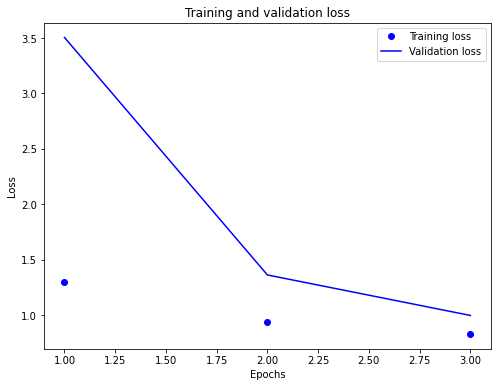

In [22]:
#loss graph for training and validation
history1=history.history
loss=history1['loss']
values=history1['val_loss']
epochs=range(1,len(loss)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
final_loss, final_acc=model.evaluate(test_dataset, verbose=0)
print("Final loss: {0:.6f}\n Final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 1.051279
 Final accuracy: 0.664418
